## Training an image classifier

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:

transform = transforms.Compose( #On combine plusieurs transformations en une seule
    [transforms.ToTensor(), # On convertit une image ou un tableau en tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # On normalise les images avec un écart type de 0.5
                                                              # et une moyenne de 0.5 pour chaque canal RGB.
batch_size = 4 # On définit le nombre d'images traités en même temps par le modèle.

## Initialisation du jeu d'entrainement ##

# On télécharge le jeu de donnée
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, #train = True indique que c'est l'ensemble du jeu d'entrainement
                                        download=True, transform=transform) # On applique la transformation

# On crée un chargeur de données qui gère l'itération sur l'ensemble de données par lots.
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, #Nombre d'image par lot
                                          shuffle=True, num_workers=2) #On mélange les données et on utilise 2 sous-processus

## Initialisation du jeu de test ##

#Même principe que pour le jeu d'entrainement
testset = torchvision.datasets.CIFAR10(root='./data', train=False, # train = false car c'est l'ensemble pour tester le modèle
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

#On définit le nom des différentes classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 67191941.37it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


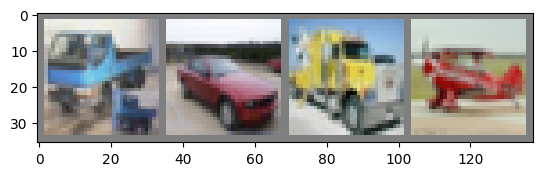

truck car   truck plane


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5 #On fait la transformée inverse, on ramène les valeurs des pixels dans [0,1]
    npimg = img.numpy() #On transforme le tensor en image numpy
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #On réorganise les tableaux pour pouvoir les affichers
    plt.show() #On affiche l'image


dataiter = iter(trainloader) # On crée un itérateur sur les données d'entrainement
images, labels = next(dataiter) #On récupère le prochain lot d'image grâce à l'itérateur

imshow(torchvision.utils.make_grid(images)) # On affiche les images
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size))) #labels

## Define a Convolutional Neural Network

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) #couche convolutive, 3 canaux d'entrée, 6 canaux de sortie et un noyau 5x5
        self.pool = nn.MaxPool2d(2, 2) #On crée des fenêtre de taille 2x2 où on assigne le max de chaque fenêtre.
        self.conv2 = nn.Conv2d(6, 16, 5) #couche convolutive, 6 canaux d'entrée, 16 canaux de sortie et un noyau 5x5
        self.fc1 = nn.Linear(16 * 5 * 5, 120) #couche connectée, 16x5x5 = 400 entrées, 120 sorties.
        self.fc2 = nn.Linear(120, 84) #2ème couche connectée 120 entrées et 84 sorties
        self.fc3 = nn.Linear(84, 10) #3ème couche connectée 84 entrées pour 10 sorties représentants les 10 classes à prédire.

    def forward(self, x): #forward pass
        x = self.pool(F.relu(self.conv1(x)))
        # ReLU introduit de la non-linéarité au model en remplaçant les valeurs négatives par zéro.
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # On transforme une matrice multidimensionnelle en vecteur unidimensionnel
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## Define a Loss function and optimizer

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss() #On définit la fonction de perte
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) #On créer un optimiseur SGD

## Train the network

In [7]:
for epoch in range(2):  #Le modèle parcourt les données 2 fois.

    running_loss = 0.0 #On initialise la perte cumulée sur chaque parcourt
    for i, data in enumerate(trainloader, 0): #On parcourt les données d'entrainement

        inputs, labels = data

        # On réinitialise les gradients de chaque paramètre à 0.
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels) #On calcule la perte.
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item() #On ajoute la perte à la perte cumulée
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.194
[1,  4000] loss: 1.899
[1,  6000] loss: 1.710
[1,  8000] loss: 1.582
[1, 10000] loss: 1.515
[1, 12000] loss: 1.466
[2,  2000] loss: 1.414
[2,  4000] loss: 1.376
[2,  6000] loss: 1.367
[2,  8000] loss: 1.315
[2, 10000] loss: 1.315
[2, 12000] loss: 1.287
Finished Training


In [8]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## Test the network on the test data

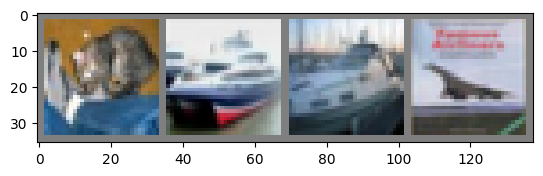

GroundTruth:  cat   ship  ship  plane


In [9]:
dataiter = iter(testloader) # On crée un itérateur sur les données d'entrainement
images, labels = next(dataiter) #On récupère le prochain lot d'image grâce à l'itérateur

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [10]:
net = Net() #On crée une instance du réseau de neurone.
net.load_state_dict(torch.load(PATH, weights_only=True)) #On charge les poids pré-enregistré dans PATH

<All keys matched successfully>

In [11]:
outputs = net(images) # On passe les images à travers le modèle

In [12]:
_, predicted = torch.max(outputs, 1) #On prends les indices avec les scores les plus élevé pour chaque image.

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   car   car   plane


In [13]:
correct = 0 #Compteur d'images correctes
total = 0 #Compteur de nombre d'images testées
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader: #On boucle sur nos données de test
        images, labels = data
        outputs = net(images) #On passe les images à travers le modèle pour les prédires
        _, predicted = torch.max(outputs.data, 1) #On prends l'indice de classe le plus élevée pour chaque image
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 53 %


In [14]:
# On calcul la précision pour chaque classe
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader: #On boucle sur nos données de test
        images, labels = data
        outputs = net(images) #On passe les images à travers le modèle pour les prédires
        _, predictions = torch.max(outputs, 1) #On prends l'indice de classe le plus élevée pour chaque image
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 51.4 %
Accuracy for class: car   is 69.2 %
Accuracy for class: bird  is 24.8 %
Accuracy for class: cat   is 27.7 %
Accuracy for class: deer  is 61.4 %
Accuracy for class: dog   is 24.4 %
Accuracy for class: frog  is 60.3 %
Accuracy for class: horse is 81.0 %
Accuracy for class: ship  is 73.1 %
Accuracy for class: truck is 63.9 %


## Training on GPU

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # On vérifie si un gpu est disponible sinon cpu

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


In [16]:
net.to(device) #On déplace le modèle sur device (gpu ou cpu)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [17]:
inputs, labels = data[0].to(device), data[1].to(device) #On déplace les données sur device

In [18]:
del dataiter #On supprime l'itérateur pour libérer de la mémoire